# Visualizing Sentiment Scores

## Python Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn2
pd.options.display.max_rows = 100

In [2]:
# import sys
# sys.path.insert(1, '../src')
# from data_read_in import get_tweets
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib_venn import venn3
# from matplotlib_venn import venn2
# pd.options.display.max_rows = 100

# tweets = get_tweets(data_path='../data/processed/', file='geotagged_text_20190715.csv')
# tweets['tweet_id'] = pd.to_numeric(tweets['tweet_id'])

In [82]:
filename = 201101

In [65]:
df_liwc = pd.read_csv('../data/features/sentiment_{}_liwc.csv'.format(filename))
df_hedono = pd.read_csv('../data/features/sentiment_{}_hedono.csv'.format(filename))
df_emoji = pd.read_csv('../data/features/sentiment_{}_emoji.csv'.format(filename))
tweets = pd.read_csv('../data/02_processed/info_{}.csv'.format(filename))

In [66]:
del tweets['lang']

# Do the Langugage Imputation
hit_count_cols = [col for col in list(df_liwc) if col[:10]=="hit_count_"]
df_liwc['hit_count'] = df_liwc[hit_count_cols].max(axis=1)
df_liwc['lang'] = df_liwc[hit_count_cols].idxmax(axis = 1, skipna = True).str.replace('hit_count_', '')
df_liwc['score'] = df_liwc.lookup(df_liwc.index, df_liwc['lang'].apply(lambda x: 'score_'+x))
df_liwc.loc[df_liwc['hit_count']==0, 'lang'] = np.nan
df_liwc = df_liwc[['tweet_id', 'lang', 'hit_count', 'score']]

# Merge language imputation onto hedonometer
df_hedono['lang'] = df_liwc['lang']
df_hedono.loc[df_hedono['lang'].isin(['en', np.nan])==False, 'score'] = np.nan
df_hedono.loc[df_hedono['lang'].isin(['en', np.nan])==False, 'hit_count'] = 0
df_hedono.loc[df_hedono['hit_count']<3, 'hit_count'] = 0
df_hedono.loc[df_hedono['hit_count']<3, 'score'] = np.nan
del df_hedono['lang']

In [83]:
df = pd.concat([
    tweets, 
    df_liwc.rename(columns={'score':'liwc_score', 'hit_count':'liwc_hit_count'}).drop('tweet_id', 1), 
    df_hedono.rename(columns={'score':'hedono_score', 'hit_count':'hedono_hit_count'}).drop('tweet_id', 1),
    df_emoji.rename(columns={'score':'emoji_score', 'hit_count':'emoji_hit_count'}).drop('tweet_id', 1)
], axis=1)

score_vars = [var for var in list(df) if var[-6:]=="_score"]

df['any_score'] = "No Score"
df.loc[
    (df['liwc_score'].notnull())|(df['hedono_score'].notnull())|(df['emoji_score'].notnull()), 'any_score'
] = "Score"
df.loc[df['any_score']=="No Score", 'any_score'] = "No Score (lang: "+df['lang'].astype(str)+")"

In [14]:
# df['liwc_score'] = np.where(df['indo_score'].notnull(), df['indo_score'], df['liwc_score'])
# del df['indo_score']

In [84]:
df.head()

,tweet_id,time,lat,lon,country,origin,sender_name,lang,liwc_hit_count,liwc_score,hedono_score,hedono_hit_count,emoji_score,emoji_hit_count,any_score
0,3.038483e+16,1.296079e+09,89.703623,-144.519565,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan)
1,2.844829e+16,1.295618e+09,89.568337,-99.513300,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan)
2,2.724617e+16,1.295331e+09,89.187881,-149.159519,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan)
3,2.753274e+16,1.295399e+09,89.078646,126.178778,NaN,other,googuns_staging,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan)
4,2.549842e+16,1.294914e+09,88.924990,-19.012088,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan)


In [85]:
def score_hist(var):
    plt.hist(df[df[var].notnull()][var], bins=list(np.linspace(0,1,21)))
    plt.axvline(x=0.5, c='r')
    plt.xlim(0,1)
    plt.title(var)
    plt.show()

## Coverage

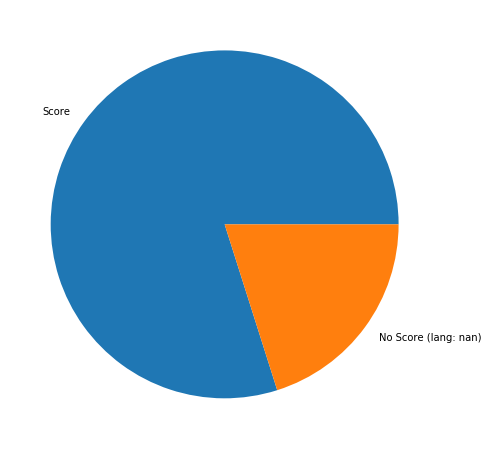

In [86]:
crosstab = df['any_score'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(8,8))
plt.pie(crosstab['any_score'], labels=crosstab['index'])
plt.show()

In [76]:
crosstab.head()

,index,any_score
0,Score,0.798887
1,No Score: nan,0.201113


## Comparing Scores

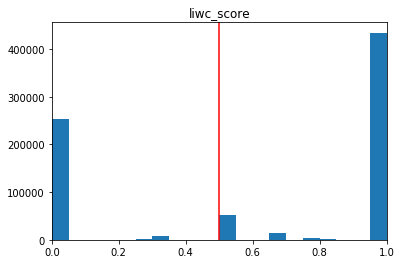

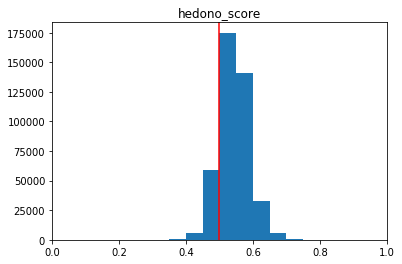

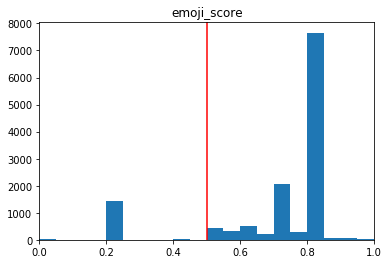

In [77]:
for var in score_vars:
    score_hist(var)

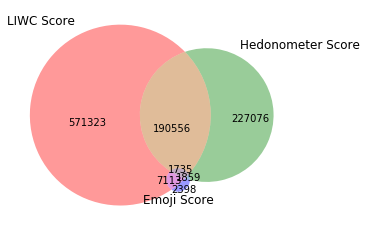

In [79]:
# Comparing Score Coverage
lst1 = list(df[df['liwc_score'].notnull()]['tweet_id'])
lst2 = list(df[df['hedono_score'].notnull()]['tweet_id'])
lst3 = list(df[df['emoji_score'].notnull()]['tweet_id'])

venn3([set(lst1), set(lst2), set(lst3)], set_labels=['LIWC Score', 'Hedonometer Score', 'Emoji Score'])
plt.show()

In [81]:
df[['liwc_score', 'hedono_score', 'emoji_score']].corr()

,liwc_score,hedono_score,emoji_score
liwc_score,1.000000,0.612747,0.071422
hedono_score,0.612747,1.000000,0.282900
emoji_score,0.071422,0.282900,1.000000


## LIWC matching by language

No data for: ['am', 'ar', 'bg', 'bn', 'bo', 'ca', 'ckb', 'cs', 'cy', 'da', 'dv', 'el', 'et', 'eu', 'fa', 'fi', 'gu', 'hi', 'ht', 'hu', 'hy', 'is', 'iw', 'ja', 'ka', 'km', 'kn', 'ko', 'lo', 'lt', 'lv', 'ml', 'mr', 'my', 'ne', 'or', 'pa', 'pl', 'ps', 'ro', 'sd', 'si', 'sl', 'sr', 'sv', 'ta', 'te', 'th', 'tl', 'tr', 'uk', 'und', 'ur', 'vi', 'zh']. 

Data for: ['de', 'en', 'es', 'fr', 'in', 'it', 'nl', 'no', 'pt', 'ru']


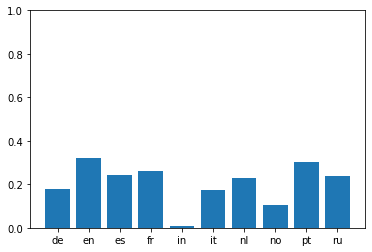

In [25]:
liwc_lang = pd.DataFrame({'lang':df['lang'], 'sentiment':[True if i==1 else False for i in df['liwc_score']]})
crosstab = pd.crosstab(liwc_lang['lang'], liwc_lang['sentiment'], normalize='index').reset_index()
in_langs = list(crosstab[crosstab[True]>0]['lang'])
out_langs = list(crosstab[crosstab[True]==0]['lang'])
print("No data for: {}. \n\nData for: {}".format(out_langs, in_langs))

crosstab_plot = crosstab[crosstab[True]>0]
plt.bar(crosstab_plot['lang'], crosstab_plot[True])
plt.ylim(0,1)
plt.show()

# Sandbox

## Spot Checking

In [ ]:
list(df[df['ag_score']>0.5]['tweet_id'])[:10]

In [ ]:
tweets['tweet_text'][list(df[df['ag_score']>0.5]['tweet_id'])[1]]

In [ ]:
tweets['tweet_text'][list(df[df['ag_score']>0.5]['tweet_id'])[3]]

In [ ]:
list(df[df['emoji_score']>0.5]['tweet_id'])[:10]

In [ ]:
tweets['tweet_text'][list(df[df['emoji_score']>0.5]['tweet_id'])[0]]

In [ ]:
tweets['tweet_text'][list(df[df['emoji_score']>0.5]['tweet_id'])[3]]

## Comparing Score Predictions

In [ ]:
subset = df[(df['ag_score'].notnull())&(df['hedonometer_score'].notnull())].copy()
pd.crosstab(subset['ag_prediction'], subset['hedonometer_prediction'], normalize=True)

In [ ]:
list(subset[(subset['ag_prediction']==0)&(subset['hedonometer_prediction']==1)]['tweet_id'])[:10]

In [ ]:
tweets['tweet_text'][list(subset[(subset['ag_prediction']==0)&(subset['hedonometer_prediction']==1)]['tweet_id'])[0]]

In [ ]:
tweets['tweet_text'][list(subset[(subset['ag_prediction']==0)&(subset['hedonometer_prediction']==1)]['tweet_id'])[3]]

### Exploring Time

In [93]:
from datetime import datetime

In [98]:
.strftime('%Y-%m-%d %H:%M:%S')

'2011-01-26 22:01:21'

In [100]:
df['year'] = df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)
df['month'] = df['time'].apply(lambda x: datetime.utcfromtimestamp(x).month)
df['day'] = df['time'].apply(lambda x: datetime.utcfromtimestamp(x).day)

In [101]:
df

,tweet_id,time,lat,lon,country,origin,sender_name,lang,liwc_hit_count,liwc_score,hedono_score,hedono_hit_count,emoji_score,emoji_hit_count,any_score,year,month,day
0,3.038483e+16,1.296079e+09,89.703623,-144.519565,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,26
1,2.844829e+16,1.295618e+09,89.568337,-99.513300,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,21
2,2.724617e+16,1.295331e+09,89.187881,-149.159519,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,18
3,2.753274e+16,1.295399e+09,89.078646,126.178778,NaN,other,googuns_staging,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,19
4,2.549842e+16,1.294914e+09,88.924990,-19.012088,NaN,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255397,2.876790e+16,1.295694e+09,-89.119242,3.143597,Antarctica,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,22
1255398,3.040861e+16,1.296085e+09,-89.256609,-141.973448,Antarctica,other,googuns_staging,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,26
1255399,3.132087e+16,1.296302e+09,-89.492687,43.825397,Antarctica,other,googuns_staging,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,29
1255400,2.812492e+16,1.295540e+09,-89.694591,-147.706353,Antarctica,other,googuns_prod,NaN,0.0,NaN,NaN,0.0,NaN,0.0,No Score (lang: nan),2011,1,20
